# Interpretable machine learning

In this week's workshop you will explore various interpretable machine learning methods. I have marked out lines where you need to fill in with #** EDIT ME **

In [27]:
!pip install lime
!pip install datasets
!pip install shap

In [28]:
import tensorflow as tf
import tensorflow.keras.layers as tkl
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#for LIME
import requests
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime import lime_image
from skimage.segmentation import mark_boundaries
from datasets import load_dataset
import skimage.segmentation
from sklearn.linear_model import Ridge

#for SHAP
import shap

In [29]:
# print the JS visualization code to the notebook
shap.initjs()

# Partial dependence plots

Let's first look at PDPs. PDPs offer a visual way to analyze the individual effects of features on model predictions. This allows us to deconstruct the complex relationships within a model and gain insights into its decision-making process.

## Load Boston housing price regresssion dataset


The Boston housing dataset is a well-established benchmark for evaluating and interpreting machine learning models. It consists of 13 attributes of houses at different locations around the Boston suburbs in the late 1970s. These include  the number of rooms, crime rate, and distance to the highway, along with the target variable of median house prices at a location (in k$). See https://lib.stat.cmu.edu/datasets/boston for column names.   



In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

In [5]:
# # start by normalising the data
# xmin = np.min(x_train, axis=0)
# xmax = np.max(x_train, axis=0)
# x_train = (x_train - xmin) / (xmax-xmin)
# x_test = (x_test - xmin) / (xmax-xmin)

# ymin = np.min(y_train)
# ymax = np.max(y_train)
# y_train = (y_train - ymin) / (ymax-ymin)
# y_test = (y_test - ymax) / (ymax-ymin)

In [125]:
# # start by normalising the data
# xmean = np.mean(x_train, axis=0)
# xstd = np.std(x_train, axis=0)
# x_train = (x_train - xmean) / xstd
# x_test = (x_test - xmean) / xstd

# ymean = np.mean(y_train)
# ystd = np.std(y_train)
# y_train = (y_train - ymean) / ystd
# y_test = (y_test - ymean) / ystd

In [15]:
tf.keras.backend.clear_session()

In [16]:
# define a feed forward model to predict the price
model = tf.keras.Sequential()
model.add(tkl.Dense(13, input_dim=13, activation='relu'))
model.add(tkl.Dense(13, activation='relu'))
model.add(tkl.Dense(5, activation='relu'))
model.add(tkl.Dense(1, activation=None))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 13)                182       
                                                                 
 dense_2 (Dense)             (None, 5)                 70        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 440 (1.72 KB)
Trainable params: 440 (1.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #define optimiser
model.compile(loss='mean_squared_error', optimizer=opt ,metrics=['MAE']) #compile model

In [20]:
# train your model
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/200
13/13 [==============================] - 0s 19ms/step - loss: 42.3975 - MAE: 4.4922 - val_loss: 49.1363 - val_MAE: 4.9870
Epoch 2/200
13/13 [==============================] - 0s 15ms/step - loss: 42.6155 - MAE: 4.4305 - val_loss: 49.1432 - val_MAE: 5.0744
Epoch 3/200
13/13 [==============================] - 0s 8ms/step - loss: 42.1071 - MAE: 4.5521 - val_loss: 49.0382 - val_MAE: 4.9375
Epoch 4/200
13/13 [==============================] - 0s 9ms/step - loss: 41.5008 - MAE: 4.4083 - val_loss: 48.3361 - val_MAE: 4.9487
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 41.0374 - MAE: 4.3788 - val_loss: 47.6540 - val_MAE: 4.9242
Epoch 6/200
13/13 [==============================] - 0s 9ms/step - loss: 40.3653 - MAE: 4.4065 - val_loss: 46.4185 - val_MAE: 4.8753
Epoch 7/200
13/13 [==============================] - 0s 9ms/step - loss: 40.5938 - MAE: 4.3086 - val_loss: 46.0097 - val_MAE: 4.8360
Epoch 8/200
13/13 [==============================] - 0s 14ms/step 

In [21]:
# This function creates a PDP plot for 1 feature
def make_pdp(data, feature_index, steps=50):
  if np.size(feature_index)==1:
    # Generate a range of values for the feature
    start = int(np.min(data[:,feature_index]))
    end = int(np.max(data[:,feature_index]))
    feature_values = np.linspace(start, end, steps)

    # Store the average predictions
    average_predictions = []

    for value in feature_values:
        # Modify the data to set the feature of interest to the current value
        modified_data = np.copy(data)
        modified_data[:, feature_index] = value

        # Make predictions
        predictions = model.predict(modified_data, verbose=0 )

        # Calculate and store the average prediction
        average_predictions.append(np.mean(predictions))

    # Plotting the PDP
    plt.plot(feature_values, average_predictions)
    plt.xlabel('Feature Value')
    plt.ylabel('Average Prediction')
    plt.title('Partial Dependence Plot')
    plt.show()

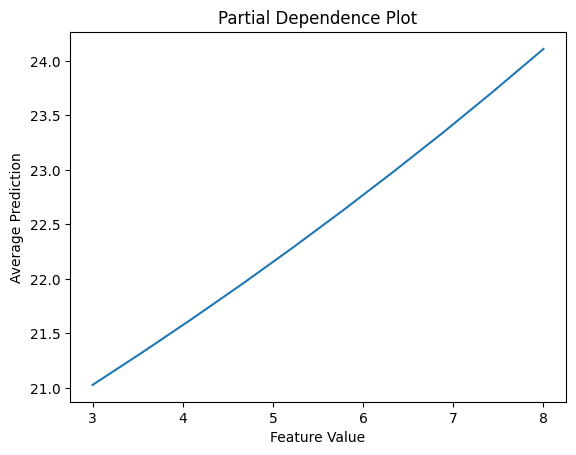

In [22]:
# plot the PDP for feature number of rooms
make_pdp(x_train, feature_index=5, steps=10)

PDP shows the average effect of house price with number of rooms. This monotonic increase suggests increase of rooms positively affects sale price.

In [23]:
# YOUR TURN, fill in this function to make a PDP plot for 2 features
def make_pdp(data, feature_index, steps=50):
    # Generate ranges of values for the two features
    start_1 = int(np.min(data[:,feature_index[0]]))
    end_1 = int(np.max(data[:,feature_index[0]]))
    start_2 = int(np.min(data[:,feature_index[1]]))
    end_2 = int(np.max(data[:,feature_index[1]]))
    feature_values_1 = np.linspace(start_1, end_1, steps)
    feature_values_2 = np.linspace(start_2, end_2, steps)


    # Initialize a grid to store the average predictions
    average_predictions = np.zeros((len(feature_values_1), len(feature_values_2)))

    # Iterate over all combinations of feature values
    for i, value_1 in enumerate(feature_values_1):
        for j, value_2 in enumerate(feature_values_2):
            # Modify the data for the current combination of feature values
            modified_data = np.copy(data)
            modified_data[:, feature_index[0]] = value_1
            modified_data[:, feature_index[1]] = value_2

            # Make predictions and store the average
            predictions = model.predict(modified_data, verbose=0)
            average_predictions[i, j] = np.mean(predictions)

    # Plotting the two-way PDP as a heatmap
    plt.imshow(average_predictions, interpolation='nearest', extent=[start_1, end_1, start_2, end_2])
    plt.xlabel('Feature 1 Value')
    plt.ylabel('Feature 2 Value')
    plt.colorbar(label='Average Prediction')
    plt.title('Two-Way Partial Dependence Plot')
    plt.show()

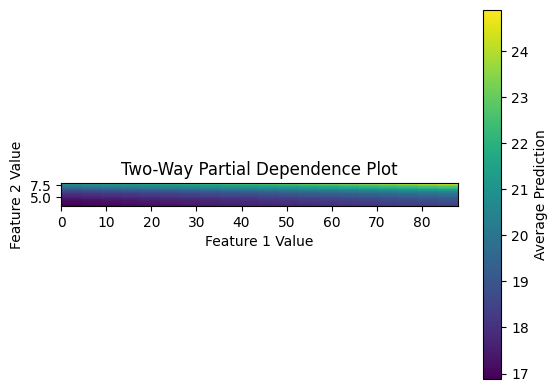

In [24]:
# plot the PDP for feature crime rate and number of bedrooms, note this takse a while to run
make_pdp(x_train, feature_index=[0,5], steps=20)

The 2way PDP shows for high numbers of bedrooms increase in crime rate relates to an high sale price (or vice versa - more crimes in affluent areas) but this relation doesnt exist in housing areas with low numbers of bedrooms, here the crime rate is stable.

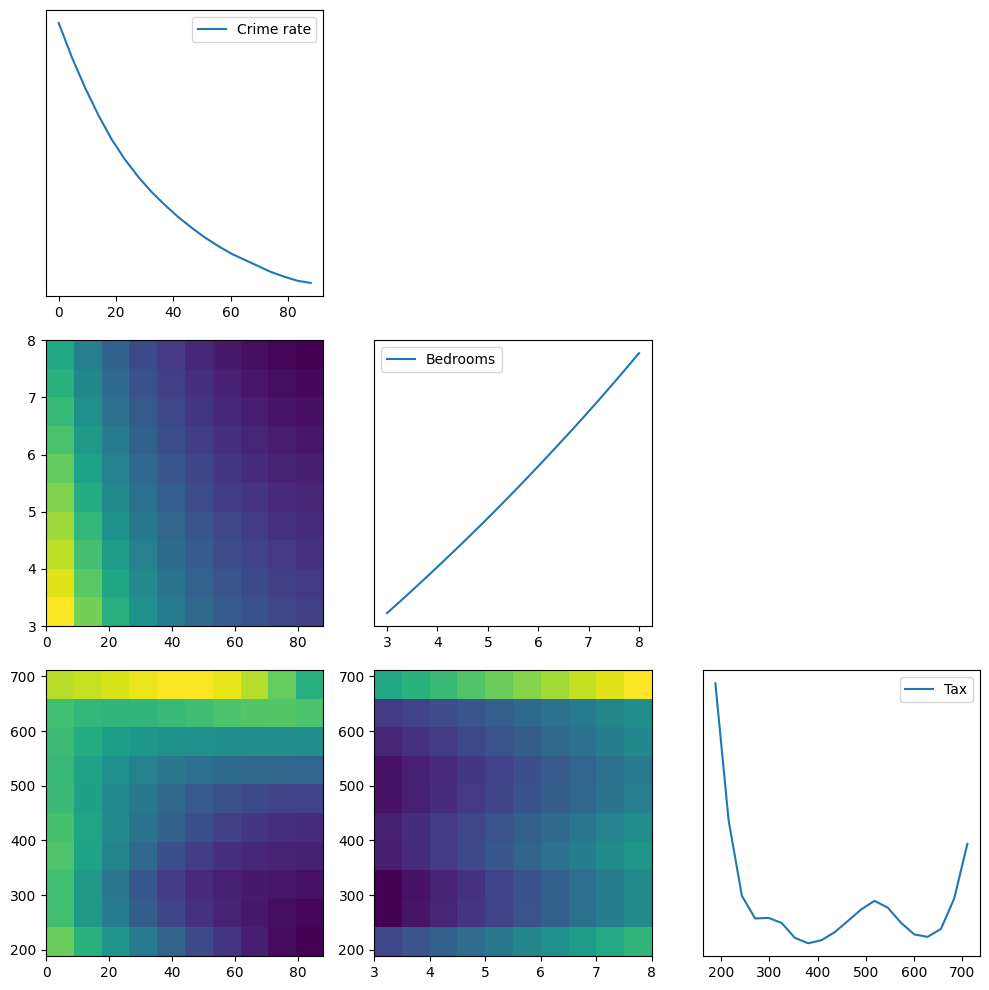

In [26]:
# You can also make triangular PDP for multiple features
def make_pdp(data, feature_index, steps=50):
  if np.size(feature_index)==1:
    # Generate a range of values for the feature
    start = int(np.min(data[:,feature_index]))
    end = int(np.max(data[:,feature_index]))
    feature_values = np.linspace(start, end, steps)
    feature_values_2 = 0

    # Store the average predictions
    average_predictions = []

    for value in feature_values:
        # Modify the data to set the feature of interest to the current value
        modified_data = np.copy(data)
        modified_data[:, feature_index] = value

        # Make predictions
        predictions = model.predict(modified_data, verbose=0 )

        # Calculate and store the average prediction
        average_predictions.append(np.mean(predictions))
  else:
    # Generate ranges of values for the two features
    start_1 = int(np.min(data[:,feature_index[0]]))
    end_1 = int(np.max(data[:,feature_index[0]]))
    start_2 = int(np.min(data[:,feature_index[1]]))
    end_2 = int(np.max(data[:,feature_index[1]]))
    feature_values = np.linspace(start_1, end_1, steps)
    feature_values_2 = np.linspace(start_2, end_2, steps)

    # Initialize a grid to store the average predictions
    average_predictions = np.zeros((len(feature_values), len(feature_values_2)))

    # Iterate over all combinations of feature values
    for i, value_1 in enumerate(feature_values):
        for j, value_2 in enumerate(feature_values_2):
            # Modify the data for the current combination of feature values
            modified_data = np.copy(data)
            modified_data[:, feature_index[0]] = value_1
            modified_data[:, feature_index[1]] = value_2

            # Make predictions and store the average
            predictions = model.predict(modified_data, verbose=0)
            average_predictions[i, j] = np.mean(predictions)

  return(feature_values, average_predictions, feature_values_2)




def make_corner_pdp(data, feature_index, classnames=None):
  nfeatures = np.size(feature_index)

  fig, axes = plt.subplots(nrows=nfeatures, ncols=nfeatures, figsize=(10, 10))

  # Loop through rows
  for i in range(nfeatures):
      # Loop through columns
      for j in range(nfeatures):
          ax = axes[i, j]

          # Diagonal: Marginal distributions
          if i == j:
            feature_values, average_predictions, feature_values_2 = make_pdp(x_train, feature_index=feature_index[i], steps=20)
            ax.plot(feature_values, average_predictions,label = classnames[i])
            ax.legend()
            ax.set_yticks([])


          # Lower triangle: Joint distributions
          elif i > j:
              feature_values, average_predictions, feature_values_2 = make_pdp(x_train, feature_index=[feature_index[i],feature_index[j]], steps=10)
              # Plotting the two-way PDP as a heatmap
              ax.imshow(average_predictions, interpolation='nearest', aspect='auto', extent=[np.min(feature_values_2), np.max(feature_values_2),np.min(feature_values), np.max(feature_values)])

          # Upper triangle: Hide these plots
          else:
              ax.set_visible(False)

          # # Set limits and labels (customize as needed)
          # ax.set_xlim(data[:, j].min(), data[:, j].max())
          # if i > j:
          #     ax.set_ylim(data[:, i].min(), data[:, i].max())

  # Adjust layout
  plt.tight_layout()
  plt.show()

make_corner_pdp(x_train, feature_index=[0,5,9], classnames=['Crime rate','Bedrooms','Tax' ])

# ICE plots
Now lets moove on to ICE plots which show individual contributions rather than the average which can help us identify outliers

In [135]:
def make_ice(data, feature_index, steps=20):
    # Generate a range of values for the feature
    start = int(np.min(data[:,feature_index]))
    end = int(np.max(data[:,feature_index]))
    feature_values = np.linspace(start, end, steps)

    predictions = np.zeros((steps, len(data)))

    for i, value in enumerate(feature_values):
        # Modify the data to set the feature of interest to the current value
        modified_data = np.copy(data)
        modified_data[:, feature_index] = value

        # Make predictions
        predictions[i,:] = model.predict(modified_data, verbose=0 )[:,0]

    for j in range(len(data)):
        anchor = predictions[0,j]
        # Plotting the ICE centred to 0 at first feature
        plt.plot(feature_values, predictions[:,j]-anchor, c='black', alpha=0.2)
    # plot average (PDP)
    average_prediction = np.mean(predictions, axis=1)
    anchor = average_prediction[0]
    plt.plot(feature_values, average_prediction-anchor, c='orange', linestyle='--')
    plt.xlabel('Feature Value')
    plt.ylabel('Partial dependence')
    plt.title('ICE Plot')
    plt.show()

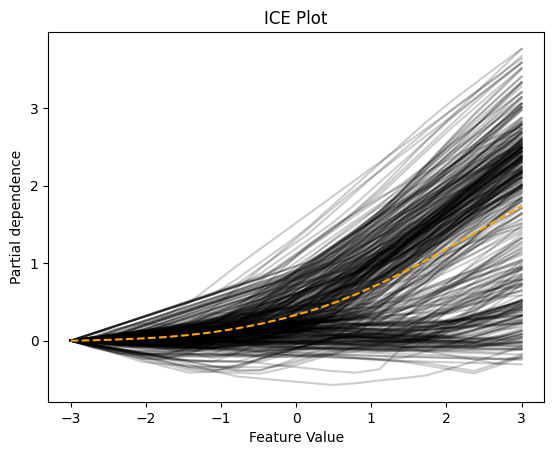

In [136]:
make_ice(x_train, feature_index=5)

Here we can see above the mean feature value (i.e. 6 bedrooms) is typically when house prices increase but there are many exceptions. No obvious outliers here.

# Using LIME with text data


PDP and ICE plots work well for tasks where predictions are continuous and features contributions are additive. For tasks with classification, whilst possible its better to look at other model agnostic methods like LIME. Here we apply it for Sentiment analysis to determine whether a text phrase is positive or negative.

In [4]:
# Load the Sentiment140 dataset from Huggingface (tfds link down)
dataset = load_dataset("sentiment140")

# Accessing the dataset
train_dataset = dataset['train']
test_dataset = dataset['test'] #we just use test set because smaller so quicker


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
# Preprocess text data (tokenization, padding)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(dataset['test']['text'])

# Tokenize and pad sequences
def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=120)
    return padded

x_seq = get_sequences(tokenizer, dataset['test']['text'])

In [6]:
y = np.array([0 if label == 0 else 1 for label in dataset['test']['sentiment']]) # positive or negative sentiments

In [7]:
# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=120),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Train model
model.fit(x_seq, y, epochs=10)

Epoch 1/10
16/16 [==============================] - 11s 119ms/step - loss: 0.6823 - accuracy: 0.6084
Epoch 2/10
16/16 [==============================] - 2s 96ms/step - loss: 0.6494 - accuracy: 0.6446
Epoch 3/10
16/16 [==============================] - 2s 105ms/step - loss: 0.6308 - accuracy: 0.6446
Epoch 4/10
16/16 [==============================] - 3s 171ms/step - loss: 0.5683 - accuracy: 0.6627
Epoch 5/10
16/16 [==============================] - 4s 257ms/step - loss: 0.4660 - accuracy: 0.8554
Epoch 6/10
16/16 [==============================] - 3s 171ms/step - loss: 0.2026 - accuracy: 0.9558
Epoch 7/10
16/16 [==============================] - 3s 178ms/step - loss: 0.0996 - accuracy: 0.9819
Epoch 8/10
16/16 [==============================] - 2s 115ms/step - loss: 0.0540 - accuracy: 0.9920
Epoch 9/10
16/16 [==============================] - 2s 120ms/step - loss: 0.0343 - accuracy: 0.9940
Epoch 10/10
16/16 [==============================] - 2s 139ms/step - loss: 0.0181 - accuracy: 0.9960

In [12]:
#predict texts
y_pred = model.predict(x_seq)

16/16 [==============================] - 2s 45ms/step


In [13]:
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Example text
idx = 0 # Index of the sample
text_to_explain = dataset['test']['text'][idx]

#LIME requires a function that takes raw text as input and outputs prediction probabilities.
def predict_text(texts):
    # Tokenize and pad the input text
    sequences = get_sequences(tokenizer, texts)
    predictions = model.predict(sequences)
    # Convert predictions to two columns, one for each of the classes
    return np.hstack((1 - predictions, predictions))


# Generate explanation, num_features determines the number of features (words) to include in the explanation.
explanation = explainer.explain_instance(text_to_explain, predict_text, num_features=5)

157/157 [==============================] - 4s 25ms/step


In [14]:
#You can use the built in visualiser to show the interpretation
explanation.show_in_notebook(text=True)

In [15]:
# Show the explanation
print(explanation.as_list())

[('cool', 0.1858121340586739), ('2', 0.166552837061119), ('Kindle2', 0.13016369324682683), ('Not', -0.0995884674072993), ('that', -0.09409414862059909)]


@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.


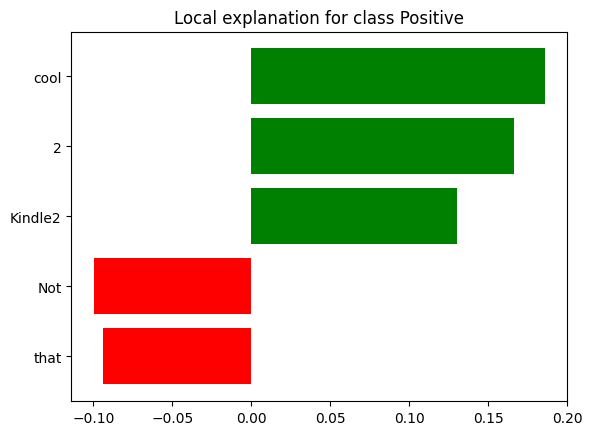

In [16]:
#alternatively you can visualise with pyplot
print(text_to_explain)
explanation.as_pyplot_figure();

# LIME on images

Again we will use the LIME package but this time apply it to a pretrained CNN model mobilenetV2.

In [30]:
# load pretrained model
model = tf.keras.applications.mobilenet_v2.MobileNetV2()

14536120/14536120 [==============================] - 0s 0us/step


In [31]:
# Load the dataset it was trained on
ds , info = tfds.load('imagenet_v2', split='test', as_supervised=True, with_info=True)

# Fetch the list of ImageNet classes
url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
imagenet_classes = requests.get(url).json()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0.incompleteT9S0A4/imagenet_v2-test.tfre…

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


In [32]:
bs = 50 #batch size

def preprocess(img, label): #normalise and reshape images for input to model
  img = img/255
  img = tf.image.resize(img, [224, 224])
  return img, label

x_train = ds.map(preprocess).batch(bs).take(1) #get dataset

In [33]:
y_pred = model.predict(x_train) #make predictions

1/1 [==============================] - 7s 7s/step


In [34]:
y_pred_idx = y_pred.argmax(axis=1) #indices of highest score prediction

In [35]:
#process datasets into numpy arrays so easier to work with
npds =  tuple(zip(*x_train))
npx = np.asarray(npds[0])[0]
npy = np.asarray(npds[1]).reshape(-1)

In [25]:
explainer = lime_image.LimeImageExplainer(verbose=False) #use image explainer on images

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 852ms/step


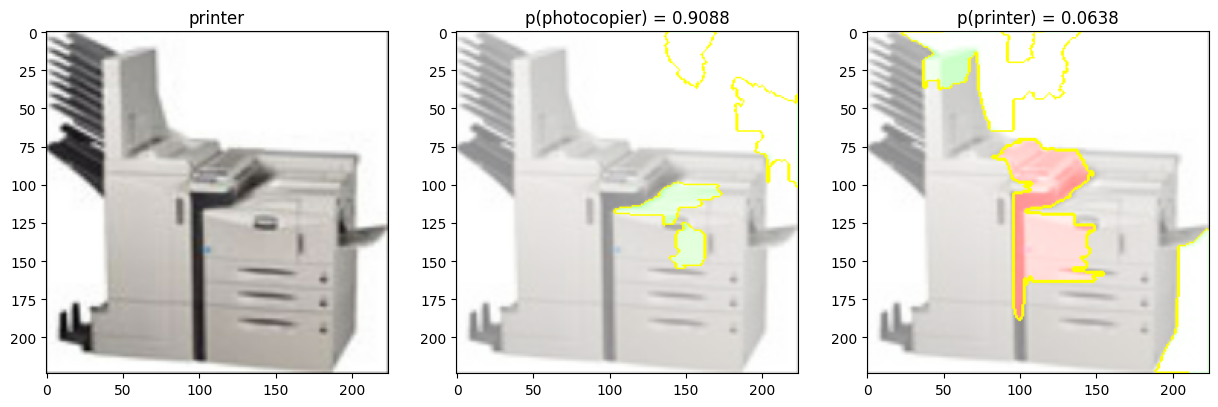

In [27]:
# Get lIME explaination of image
def get_lime(x, y, y_pred, labels, model, nlabels=2, nsamples=100):
  #x: input image
  #y: index of true label
  #y_pred: all predictions
  #labels: all labels
  #model: trained model
  #nlabels: top-n labels and explainatiions to plot
  #nsamples: number of perturbation samples, default=1000, higher values more computationally expensive

  fig, ax = plt.subplots(1, (nlabels+1), figsize=((nlabels+1)*5, 5))

  #get explainations of top prediction labels of instance
  explanation = explainer.explain_instance(x, model.predict, top_labels=nlabels, hide_color=0, num_samples=nsamples)

  #show ground truth
  ax[0].imshow(x);
  ax[0].set_title(labels[y])

  for i in range(nlabels):
    #mask important regions for each label
    #num_features=5 specifies the number of features (or in the case of images, superpixels) to include in the explanation.
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=5, hide_rest=False)

    ax[i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax[i+1].set_title('p({}) = {:.4f}'.format(labels[explanation.top_labels[i]], y_pred[explanation.top_labels[i]]))

  plt.show()

idx = 0 #look at first prediction
get_lime(npx[idx], npy[idx], y_pred[0], imagenet_classes, model)

# LIME from scratch
It's recommended that you use the official LIME package because its more robust and flexible and has loads of built in visualisation tools, but its worth taking a look how to implement LIME from scratch too.

In [81]:
# First we create perturbed versions of the image by randomly masking out regions
def perturb_image(img, segments, num_perturb=500):
    perturbed_images = []
    masks = []
    for _ in range(num_perturb):
        mask = np.zeros(segments.shape)
        # Select a random subset of segments to turn off
        off_segments = np.random.choice(np.unique(segments), replace=False, size=np.random.randint(1, len(np.unique(segments))//2))
        for segment in off_segments:
            mask[segments == segment] = 1
        perturbed_img = img * np.expand_dims(mask, axis=-1)
        perturbed_images.append(perturbed_img)
        masks.append(mask)
    return np.array(perturbed_images), np.array(masks)


idx=0 #image to interpret

# Segment image using SLIC
segments_slic = skimage.segmentation.slic(npx[idx].astype(np.float32), n_segments=50, compactness=20, sigma=1)

# Generate perturbed images by randomly masking out segments
perturbed_images, masks = perturb_image(npx[idx], segments_slic)

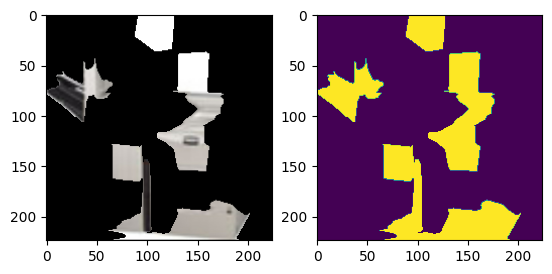

In [82]:
#plot example of perturbed image
fig, ax = plt.subplots(1,2)
ax[0].imshow(perturbed_images[0])
ax[1].imshow(masks[0]);

In [83]:
predictions = model.predict(perturbed_images) #apply model to perturbed images

16/16 [==============================] - 19s 1s/step


In [84]:
# Use the top prediction from the original image as the target class
top_prediction = y_pred[idx].argmax()

# Get the prediction probabilities for the top class
target_class_probs = predictions[:, top_prediction]

Now we train an interpretable machine learning model like linear regression or decision tree on the perturbed images' predictions, using the masks as features to approximate the local decision boundary around the original prediction.

In [92]:
# Train a Ridge model (linear regression with regularization, linear too simple)
linear_model = Ridge(alpha=1)
linear_model.fit(masks.reshape(masks.shape[0], -1), target_class_probs)

# The coefficients indicate the importance of each segment
segment_importances = linear_model.coef_.reshape(segments_slic.shape)

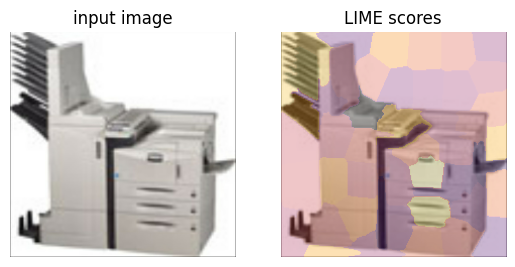

In [106]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(npx[idx])
ax[0].set_title('input image')
ax[0].axis('off');

ax[1].imshow(npx[idx])
ax[1].imshow(segment_importances, cmap='inferno', alpha=0.3)
ax[1].set_title('LIME explaination')
ax[1].axis('off');

# SHAPLEY

In the SHAP package, some explainers are not compatible with TF2 so let's use their primary explainer. This is compatible with all models

In [107]:
# create background data
masker = shap.maskers.Image("blur(128,128)", npx[idx].shape)

In [108]:
# create explainer
explainer = shap.Explainer(model, masker, output_names=imagenet_classes, algorithm='partition')

In [109]:
# Explain the image with 100 evaluation shap values, more evaluations gives more granualarity but slower to run. Would recommend 300-500. Here we show top 8 examples
shap_values = explainer(np.expand_dims(npx[idx], axis=0), max_evals=100, batch_size=10, outputs=shap.Explanation.argsort.flip[:5])

  0%|          | 0/98 [00:00<?, ?it/s]

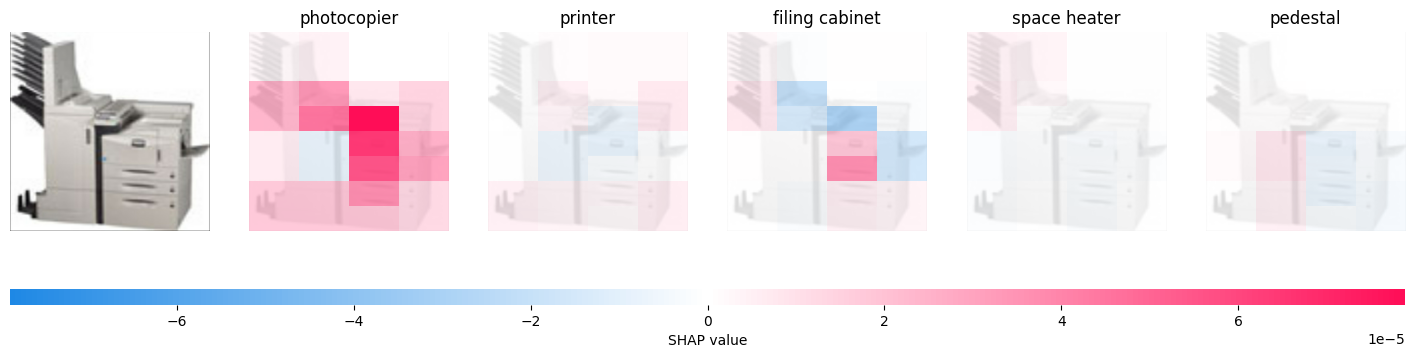

In [110]:
shap.image_plot(shap_values)

Here superpixels with positive SHAP values (red) contribute positively towards the prediction. Blue contribute negatively. We used the partition explainer which doesnt assume features (superpixels) are independent from each other. SHAP from scratch is similar to LIME with the main difference being that we substitute a set of features with their average across the sample and some spatial weighting so we will not do it here, but its worth familiarising with.

# SHAP for income prediction

In [111]:
# Load the Adult consenus dataset from Huggingface
dataset = load_dataset("scikit-learn/adult-census-income")

# Accessing the dataset
df = pd.DataFrame(dataset['train'])

# Remove rows with missing data ('?' entries)
df.replace('?', pd.NA, inplace=True)  # Replace '?' with NA
df.dropna(inplace=True)  # Drop rows with NA

Generating train split: 0 examples [00:00, ? examples/s]

In [112]:
# Separate features and target
X = df.drop(columns=['income'])
y = df['income']

# Apply one-hot encoding to categorical columns
X= pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True)

# Normalize features
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# Define the model
model = tf.keras.Sequential([
    tkl.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tkl.Dense(32, activation='relu'),
    tkl.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
679/679 [==============================] - 3s 3ms/step - loss: 0.3452 - accuracy: 0.8415 - val_loss: 0.3274 - val_accuracy: 0.8458
Epoch 2/10
679/679 [==============================] - 5s 7ms/step - loss: 0.3147 - accuracy: 0.8544 - val_loss: 0.3154 - val_accuracy: 0.8570
Epoch 3/10
679/679 [==============================] - 3s 5ms/step - loss: 0.3104 - accuracy: 0.8571 - val_loss: 0.3147 - val_accuracy: 0.8562
Epoch 4/10
679/679 [==============================] - 2s 4ms/step - loss: 0.3073 - accuracy: 0.8593 - val_loss: 0.3113 - val_accuracy: 0.8579
Epoch 5/10
679/679 [==============================] - 2s 3ms/step - loss: 0.3042 - accuracy: 0.8593 - val_loss: 0.3129 - val_accuracy: 0.8550
Epoch 6/10
679/679 [==============================] - 2s 2ms/step - loss: 0.3016 - accuracy: 0.8595 - val_loss: 0.3130 - val_accuracy: 0.8545
Epoch 7/10
679/679 [==============================] - 2s 3ms/step - loss: 0.2984 - accuracy: 0.8611 - val_loss: 0.3132 - val_accuracy: 0.8562
Epoch 

In [114]:
def f(X):
    return model.predict(X).flatten()

In [116]:
explainer = shap.KernelExplainer(f, X_train.iloc[:50, :]) #use first 50 samples as baseline/background
shap_values = explainer.shap_values(X_train.iloc[299, :], nsamples=500) #to explain sample 299

782/782 [==============================] - 1s 1ms/step


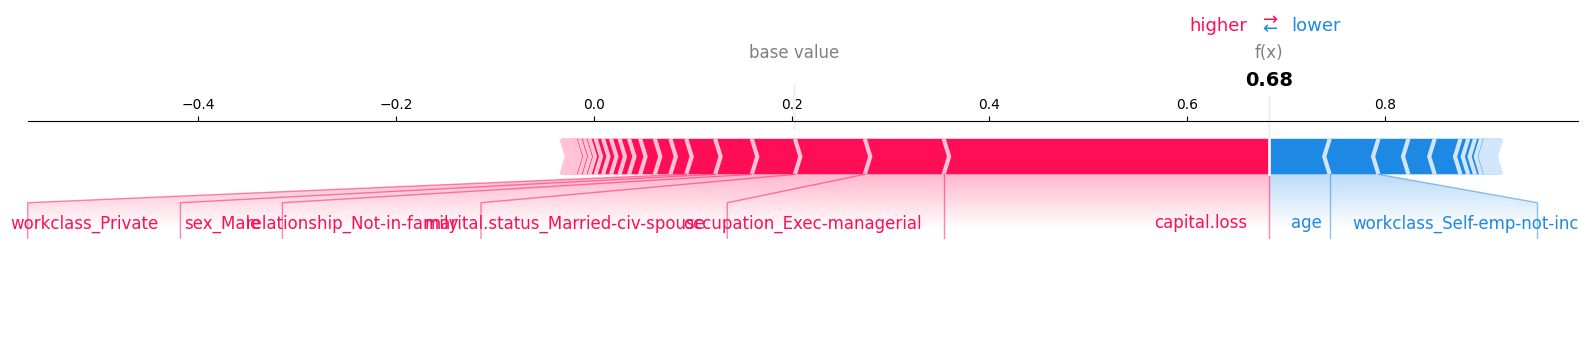

In [117]:
np.set_printoptions(precision=2)
shap.force_plot(explainer.expected_value, shap_values, X_train.columns, matplotlib=matplotlib)

In [118]:
shap_values50 = explainer.shap_values(X_train.iloc[280:330, :], nsamples=500) #explain many samples

  0%|          | 0/50 [00:00<?, ?it/s]

782/782 [==============================] - 1s 1ms/step


In [119]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50, X_train.iloc[280:330, :])

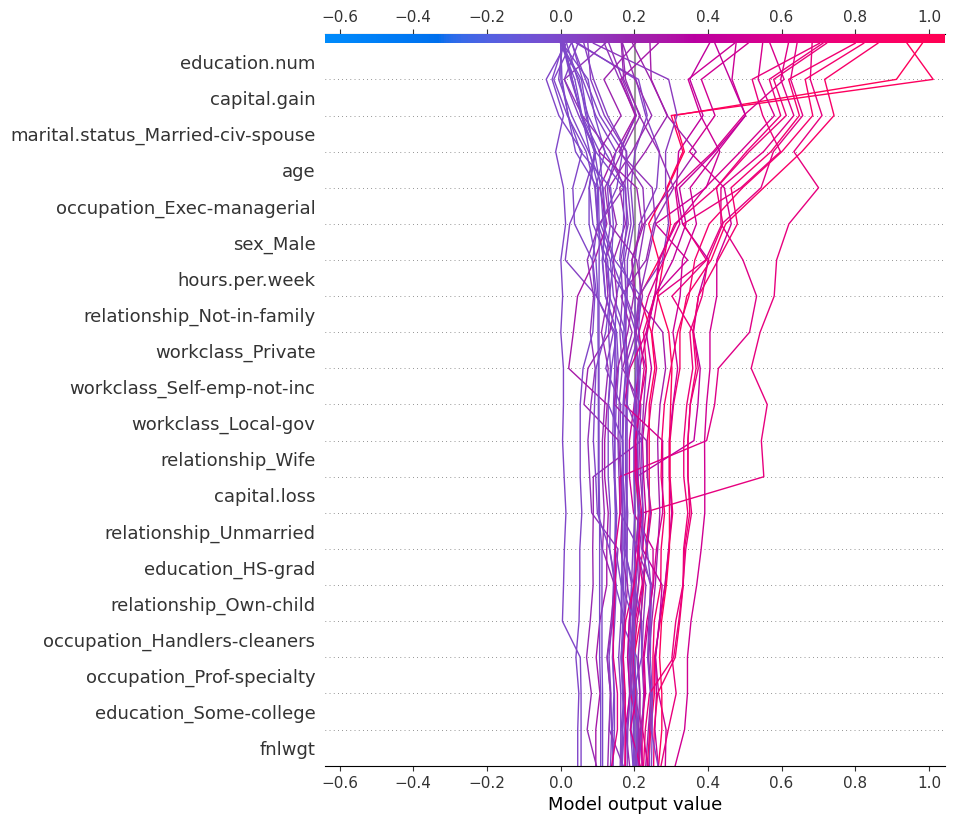

In [120]:
shap.decision_plot(explainer.expected_value, shap_values50, X_train.columns)

decision plots are clearly useful to show outliers

# Feature visualisation

Now let's focus on methods more specific to neural nets and in particular CNNs

In [36]:
# Load the pre-trained MobileNetv2 model but without the top layer to focus on convolutional layers
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [37]:
base_model.summary() #print model layers

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

In [38]:
# Create a new model that outputs the activations of a specific layer
layer_name = 'Conv_1' #'block_10_expand'  # Choose the layer
layer_output = base_model.get_layer(layer_name).output
model = tf.keras.Model(inputs=base_model.input, outputs=layer_output)

In [39]:
idx = 3 # choose an image to explain

activation_map = model(tf.expand_dims(npx[idx], axis=0))

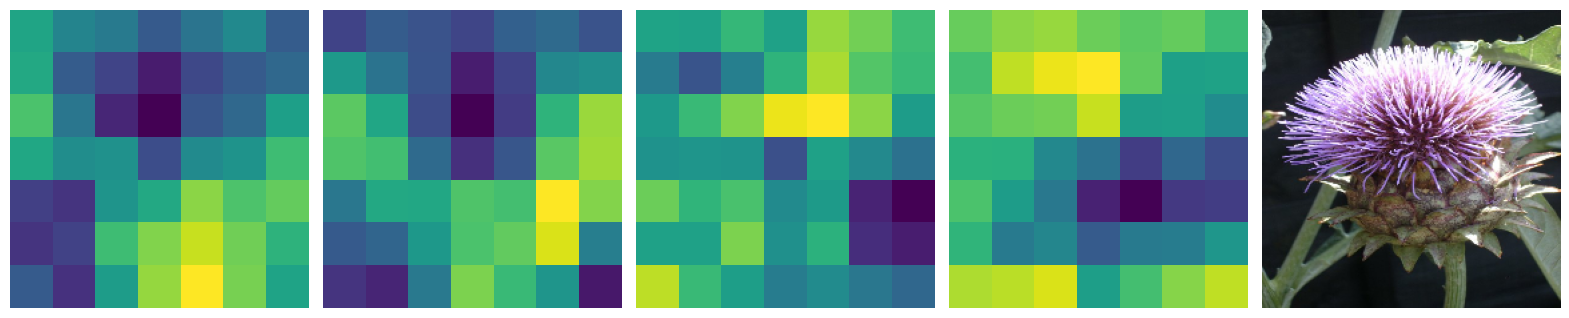

In [40]:
#plot first 4 filters and the input image

fig, ax = plt.subplots(1,5, figsize=(20,5),gridspec_kw = {'wspace':0.05, 'hspace':0})
for i in range(4):
  ax[i].imshow(activation_map[0,:,:,i])
  ax[i].set_axis_off()

ax[4].imshow(npx[idx])
ax[4].set_axis_off();

In [41]:
# Deprocess the image and make sure its within [0,255] pixel values
def deprocess_image(x):
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to generate patterns for filters
def generate_pattern(filter_index, size=224, steps=50, step_size=0.1):
    input_img_data = tf.random.uniform((1, size, size, 3)) #start with randomly initisalised image

    # Run gradient ascent to maximise loss
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            activation = model(input_img_data)
            loss = tf.reduce_mean(activation[..., filter_index])

        grads = tape.gradient(loss, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5) #normalise gradient by rms and small epsilon value for stability
        input_img_data += normalized_grads * step_size

    img = input_img_data[0].numpy()
    return deprocess_image(img)

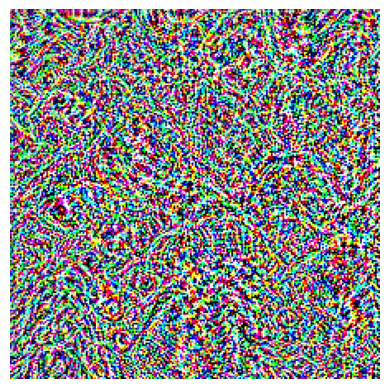

In [46]:
# Filter index to visualize
filter_index = 5  # Can be any valid index of a filter in the chosen layer

# Generate the pattern for a specific filter
plt.imshow(generate_pattern(filter_index))
plt.axis('off');

# Saliency
feature visualisation is great, and looks amazing but practically its not feasible to visually inspect each filter, and its not always obvious what its showing anyway. Instead let's try to interpret directly on the image, which parts are important in a model's decision making process

In [47]:
# we first need to load the full pretrained mobilenet again, (including top layer)
model = tf.keras.applications.mobilenet_v2.MobileNetV2()

In [53]:
npy[32]

36

flagpole


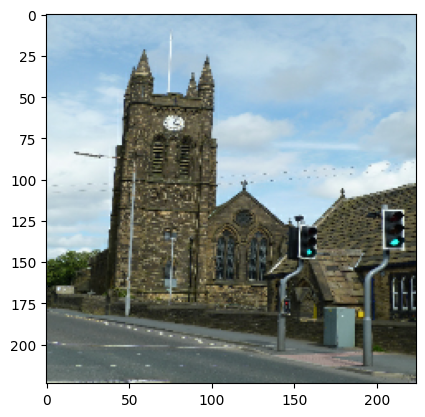

In [57]:
idx=46

plt.imshow(npx[idx])
print(imagenet_classes[npy[idx]])

In [65]:
idx = 32 #choose image
image = tf.expand_dims(npx[idx],axis=0) #reshape input image

# Choose the index of the output class you want to visualize
class_idx = npy[idx]

# Get the gradients of the loss w.r.t the input image
with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss_value = prediction[:,class_idx]

grads = tape.gradient(loss_value, image)

# Normalize the gradients
grads = tf.dtypes.cast(grads, tf.float32)
normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)

# Take absolute gradients as saliency map
saliency_map = np.abs(normalized_grads.numpy())[0]

In [66]:
#for visualisation, we aggregate across channels, here we take the maximum, but you could do mean
saliency_map_gray = np.max(saliency_map, axis=-1)

# Normalize the saliency map for better visualization
norm_saliency_map = (saliency_map_gray - np.min(saliency_map_gray)) / (np.max(saliency_map_gray) - np.min(saliency_map_gray))

(-0.5, 223.5, 223.5, -0.5)

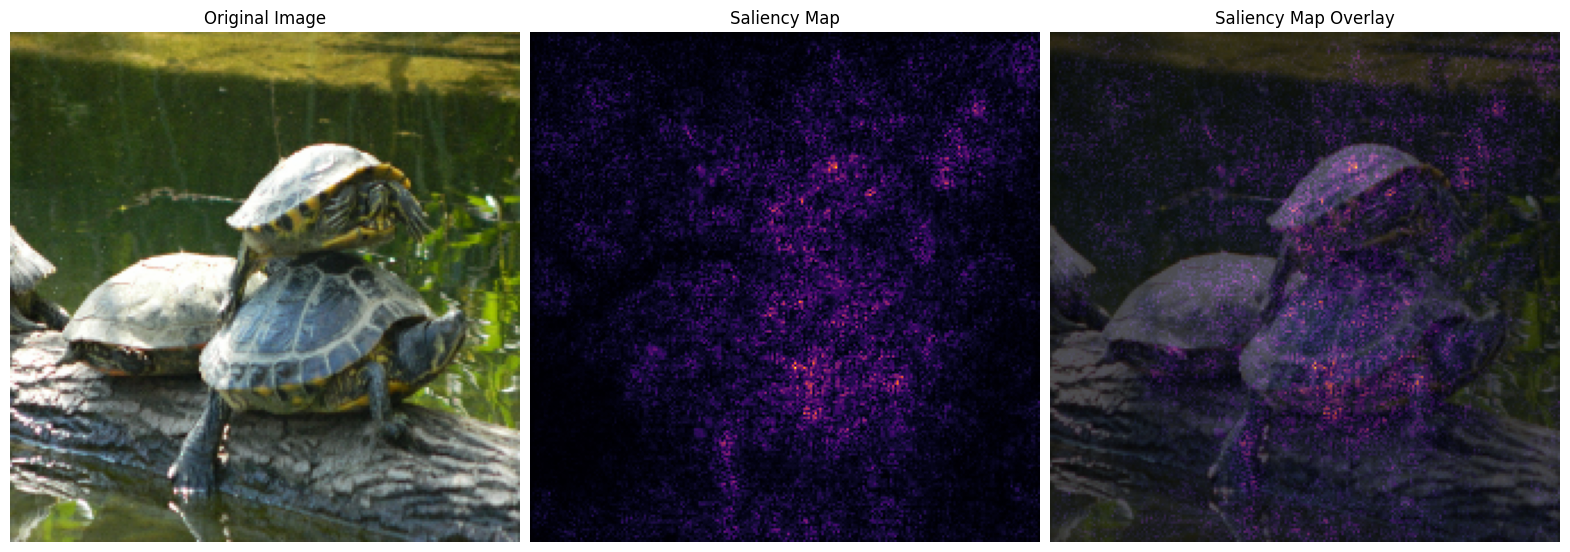

In [72]:
# Make Saliency plots
fig,ax = plt.subplots(1,3,figsize=(20, 15),gridspec_kw = {'wspace':0.02, 'hspace':0})

# Display original image
ax[0].set_title('Original Image')
ax[0].imshow(image[0])
ax[0].axis('off')

ax[1].set_title('Saliency Map')
ax[1].imshow(norm_saliency_map, cmap='inferno')  # Overlay the saliency map with transparency
ax[1].axis('off');

# Display heatmap overlay on the original image
ax[2].set_title('Saliency Map Overlay')
ax[2].imshow(image[0])  # Show the original image
ax[2].imshow(norm_saliency_map, cmap='inferno', alpha=0.7)  # Overlay the saliency map with transparency
ax[2].axis('off')



# GradCAM
The results of the saliency map can be difficult to interpret as they are too fine. Instead backprop to the last layer only to get a more class specific interpretation.

In [68]:
# Create a new model that outputs the activations of a specific layer
layer_name = 'Conv_1'  # Choose the layer (usually the last layer)

#first model outputs layer, second outputs predictions
CAM_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

In [69]:
# Compute gradients wrt output of layer
with tf.GradientTape() as tape:
  conv_outputs, predictions = CAM_model(image)
  loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)

# Pool the gradients across the channels
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight the outputs with the computed gradients and sum
conv_outputs = conv_outputs[0]
weighted_conv_outputs = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Apply ReLU to the weighted feature map
heatmap = tf.maximum(weighted_conv_outputs, 0) / tf.math.reduce_max(weighted_conv_outputs)
heatmap = heatmap.numpy()

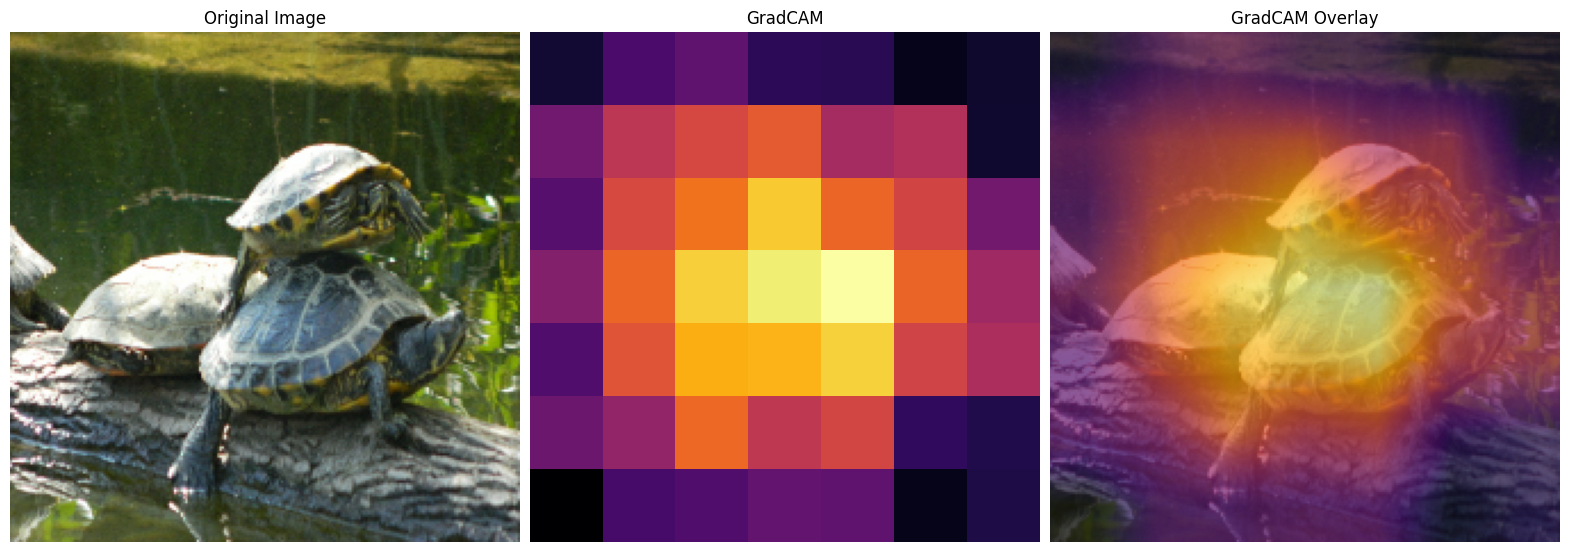

In [70]:
#Visualise heatmap
fig,ax = plt.subplots(1,3,figsize=(20, 15),gridspec_kw = {'wspace':0.02, 'hspace':0})

# Display original image
ax[0].set_title('Original Image')
ax[0].imshow(image[0])
ax[0].axis('off')

# Display heatmap
ax[1].set_title('GradCAM')
ax[1].imshow(heatmap, cmap='inferno')
ax[1].axis('off');


# Display heatmap overlay on the original image
upscaled_heatmap = tf.image.resize(np.expand_dims(heatmap,axis=-1), [224,224]).numpy()
ax[2].set_title('GradCAM Overlay')
ax[2].imshow(image[0])  # Show the original image
ax[2].imshow(upscaled_heatmap, cmap='inferno', alpha=0.7)  # Overlay the gradCAM map with transparency
ax[2].axis('off');

# Guided Grad CAM

In contrary to the saliency map, GradCAM is perhaps too coarse. Let's combine the two.

In [71]:
guided_gradCAM = upscaled_heatmap[:,:,0] * norm_saliency_map

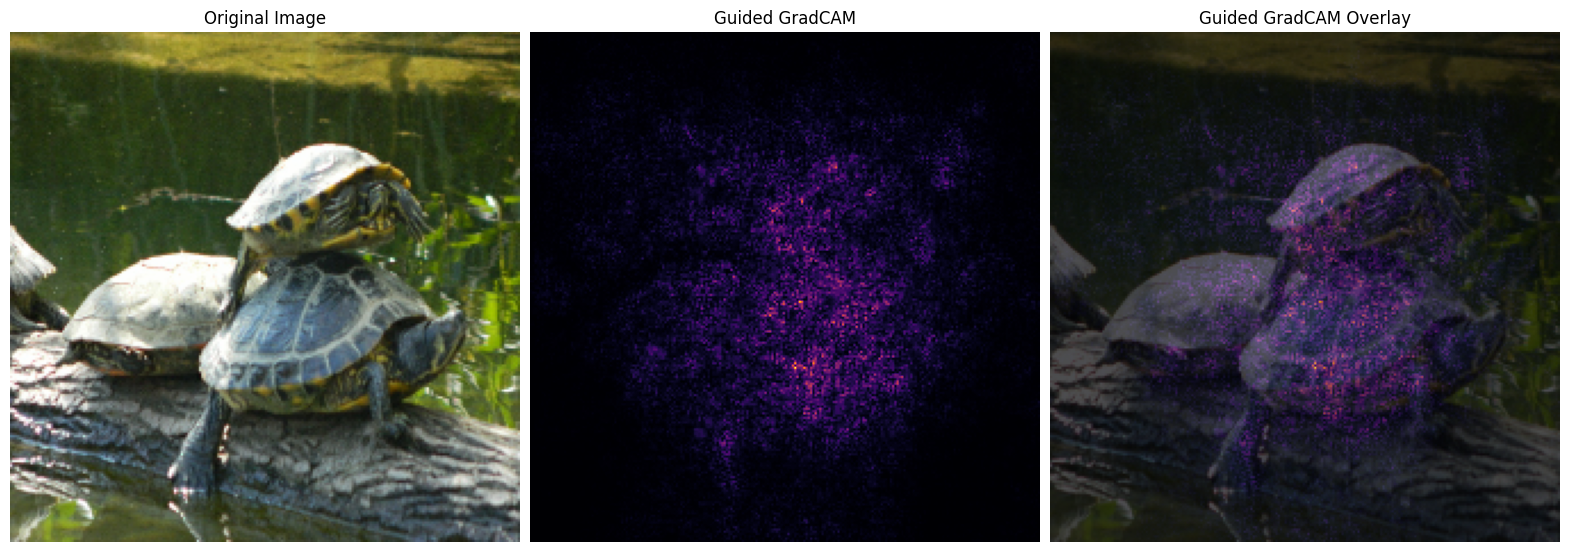

In [139]:
#Visualise heatmap
fig,ax = plt.subplots(1,3,figsize=(20, 15),gridspec_kw = {'wspace':0.02, 'hspace':0})

# Display original image
ax[0].set_title('Original Image')
ax[0].imshow(image[0])
ax[0].axis('off')

# Display heatmap
ax[1].set_title('Guided GradCAM')
ax[1].imshow(guided_gradCAM , cmap='inferno')
ax[1].axis('off');


# Display heatmap overlay on the original image
upscaled_heatmap = tf.image.resize(np.expand_dims(heatmap,axis=-1), [224,224]).numpy()
ax[2].set_title('Guided GradCAM Overlay')
ax[2].imshow(image[0])  # Show the original image
ax[2].imshow(guided_gradCAM , cmap='inferno', alpha=0.7)  # Overlay the gradCAM map with transparency
ax[2].axis('off');